# Pure Open Markets: Backtesting the Optimal Strategy

# 0. Setup

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds

WRDS_LOGIN = 'pedrou'    # update to your login info on CRSP
DATAPATH = '~/Downloads/mathematical_finance/data/'

### Check which databases are there stored in the `CRSP_monthly_cleaned.h5` dataframe.

In [91]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly_cleaned.h5') as store:
    # Get the first level of the MultiIndex (column names)
    column_names = store['df'].columns.get_level_values(0)
    
    # Convert the column names to a set to get unique values
    unique_column_names = set(column_names)
    
    print('Databases in CRSP_monthly_cleaned: ' + str(unique_column_names))
    print(store.keys())

Databases in CRSP_monthly: {'mthprevcap', 'mthret', 'bcktstflg'}
['/df']


# 1. Selecting the Dataset

## 1.1. Choosing the Investment Universe and Time Period

The Investment Universe is made up of all the common shares. Johannes Ruf defines common shares as those who satisfy the following conditions:

a) `sharetype` equals `NS` ('not specified', other types could be ADRs or certificates, for example);

b) `securitysubtype` equals `COM` (for `common`, other types could be closed-end funds, for example);

c) `issuertype` is either `ACOR` or `CORP` ((assumed) corporation; there is only one other type, namely REITs);

d) `usincflg` equals `Y` (US-incorporated).

There is another relevant column, namely `securitytype`, which describers whether the security is a stock, a derivative, or a fund. However, we don't have to check it since condition a) above already implies that `securitytype` always equals `EQTY`.

In [92]:
db = wrds.Connection(wrds_username='pedrou')

n_of_assets = db.raw_sql("""SELECT d.dlycaldt, COUNT(*) AS nobs FROM crsp.StkDlySecurityPrimaryData AS d
                            JOIN crsp.StkSecurityInfoHist AS i
                            ON d.permno = i.permno AND i.secinfostartdt <= d.dlycaldt 
                            AND d.dlycaldt <= i.secinfoenddt
                            WHERE i.sharetype = 'NS' AND i.securitysubtype = 'COM' 
                            AND i.issuertype IN ('ACOR','CORP') AND i.usincflg = 'Y'
                            GROUP BY d.dlycaldt
                          """, date_cols='dlycaldt')
n_of_assets = n_of_assets.set_index('dlycaldt')


Loading library list...
Done


First time when there were more than 3000 stocks was 1972-12-14 00:00:00


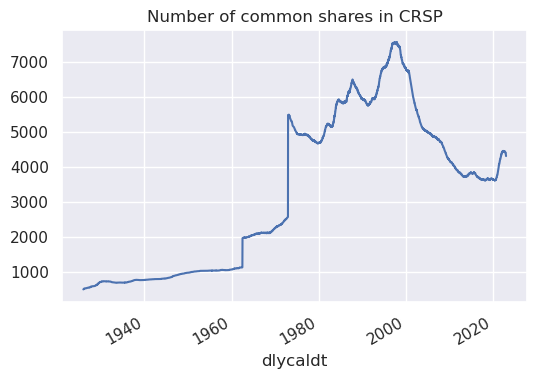

In [93]:
d = 3000
first_date_with_nobs_gt_d = n_of_assets[n_of_assets['nobs'] > d].first_valid_index()
print('First time when there were more than '+str(d)+' stocks was '+str(first_date_with_nobs_gt_d))
n_of_assets.plot(title='Number of common shares in CRSP', figsize=(6, 4), legend=False);

From this plot we can see that if we choose d to be 3000 and we only work with data from 1973                                    onwards, we can be sure that we always have d stocks in our investment universe. So we will just take d = 3000 and our investment universe at any time will be defined as the biggest d stocks. However, this setting might have some problems, as what would happen if the stock at position 3000 gets replaced by the stock at position d-1? Is the stock set to 0 and we assume we have lost all? This is probably not a good idea. 

When a company drops out of the top 'd' in our investment universe, we will need to adjust your portfolio during the rebalancing process. We will follow these steps when an investment we had in the company that's no longer in the top 'd':

1. Sell the position: When rebalancing the portfolio, sell the entire position we had in the stock that's no longer in the top 'd'. This frees up the capital that was invested in that stock.

2. Allocate the freed capital: Use the capital obtained from selling the position to invest in the new stock(s) that have entered the top 'd' of then investment universe. This ensures that your portfolio remains aligned with the updated investment universe.

3. Adjust portfolio weights: After reallocating the capital to the new stock(s), recompute the portfolio weights based on the trading strategy. This may involve equal weighting, market capitalization weighting, or other weighting schemes defined by the strategy.

4. Continue monitoring and rebalancing: Keep monitoring the investment universe and perform periodic rebalancing to ensure that the  portfolio remains aligned with the updated universe and follows the trading strategy.

However, for simplicity first, and to construct the backtesting strategy incrementally, we will just select the top d strategies at the beginning of 1973 and do our analysis first without changing this stocks.

## 1.2. Creating the Dataframe to Work With

Let's create the dataframe with monthly data since 1973, where we will be only looking at the performance until now of top d stocks in 1973. The resulting dataframe will contain, for each month and permno:
- Its total market capitalization.
- Its relative market capitalization.
- Its rank.
- Its return for that time period.

### Step 1: Prepare Market Capitalizations Dataset.

In [94]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly_cleaned.h5') as store:
    mktcaps_raw = store['df']['mthprevcap']

#### Step 1.0: Understanding `mkcaps`.

In [95]:
# Access a specific value using row and column index:
value = mktcaps_raw.loc['1926-01-30', 10006.0]
value

65400.0

In [96]:
print("\nConcise summary of the DataFrame:")
print(mktcaps_raw.info())


Concise summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1164 entries, 1926-01-30 to 2022-12-30
Columns: 26480 entries, 10000.0 to 93436.0
dtypes: float64(26480)
memory usage: 235.2 MB
None


In [97]:
# Access an entire row using the row index:
row = mktcaps_raw.loc['1926-01-30']
print(len(row))
row.head(7)

26480


permno
10000.0        NaN
10001.0        NaN
10002.0        NaN
10003.0        NaN
10004.0        NaN
10005.0        NaN
10006.0    65400.0
Name: 1926-01-30 00:00:00, dtype: float64

In [98]:
# Access an entire column using the column index:
column = mktcaps_raw[10006.0]
print(len(column))
column.head(5)

1164


mthcaldt
1926-01-30    65400.0
1926-02-27    66150.0
1926-03-31    61425.0
1926-04-30    57900.0
1926-05-28    56400.0
Name: 10006.0, dtype: float64

In [99]:
# Select a subset of the DataFrame using slicing:
subset = mktcaps_raw.loc['1926-01-30':'1926-03-31', 10006.0:10008.0]
subset

permno,10006.0,10007.0,10008.0
mthcaldt,,,
1926-01-30,65400.0,NaN,NaN
1926-02-27,66150.0,NaN,NaN
1926-03-31,61425.0,NaN,NaN


In [100]:
# Using iloc to access elements by position (row and column number):
element = mktcaps_raw.iloc[0, 6]
element

65400.0

In [101]:
# Access values based on a condition:
selected_values = mktcaps_raw[mktcaps_raw > 1000]
selected_values.head(3)

permno,10000.0,10001.0,10002.0,10003.0,10004.0,10005.0,10006.0,10007.0,10008.0,10009.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1926-01-30,NaN,NaN,NaN,NaN,NaN,NaN,65400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-02-27,NaN,NaN,NaN,NaN,NaN,NaN,66150.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-31,NaN,NaN,NaN,NaN,NaN,NaN,61425.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# Apply a function to each element in the DataFrame:
def double(x):
    return 2 * x
doubled_mktcaps = mktcaps_raw.applymap(double)
print(doubled_mktcaps.head(3))

permno      10000.0  10001.0  10002.0  10003.0  10004.0  10005.0   10006.0  \
mthcaldt                                                                     
1926-01-30      NaN      NaN      NaN      NaN      NaN      NaN  130800.0   
1926-02-27      NaN      NaN      NaN      NaN      NaN      NaN  132300.0   
1926-03-31      NaN      NaN      NaN      NaN      NaN      NaN  122850.0   

permno      10007.0  10008.0  10009.0  ...  93423.0  93426.0  93428.0  \
mthcaldt                               ...                              
1926-01-30      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1926-02-27      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1926-03-31      NaN      NaN      NaN  ...      NaN      NaN      NaN   

permno      93429.0  93430.0  93432.0  93433.0  93434.0  93435.0  93436.0  
mthcaldt                                                                   
1926-01-30      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1926-02-27     

#### Step 1.1: Remove data before 1973

In [103]:
start_date = '1973-01-31'
mktcaps_1973 = mktcaps_raw[mktcaps_raw.index >= start_date]
mktcaps_1973.head(3)

permno,10000.0,10001.0,10002.0,10003.0,10004.0,10005.0,10006.0,10007.0,10008.0,10009.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,NaN,NaN,NaN,NaN,NaN,NaN,266985.75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,NaN,NaN,NaN,NaN,NaN,NaN,250868.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-30,NaN,NaN,NaN,NaN,NaN,NaN,228444.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 1.2: Select only top `d` stocks at the beginning of 1973

Identify the top d stocks with the highest market capitalization at the beginning of 1973.

In [104]:
d = 3000 
top_d_stocks = mktcaps_1973.loc[start_date].nlargest(d).index
top_d_stocks[0:3]

Float64Index([12490.0, 10401.0, 11754.0], dtype='float64', name='permno')

Filter the market capitalization data to include only the top d stocks.

In [105]:
mktcaps_1973_top = mktcaps_1973.loc[:, top_d_stocks]
mktcaps_1973_top.tail(3)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-10-31,1.073068e+08,NaN,NaN,NaN,3.638763e+08,NaN,67887596.23,2034855.60,NaN,62941242.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171180.00
2022-11-30,1.250316e+08,NaN,NaN,NaN,4.618157e+08,NaN,85020497.08,2276471.89,NaN,69529541.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164160.00
2022-12-30,1.346244e+08,NaN,NaN,NaN,4.585307e+08,NaN,93936667.96,2537884.93,NaN,69629035.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157995.36


### Step 2: Prepare the Returns Dataset.

In [106]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly_cleaned.h5') as store:
    raw_returns = store['df']['mthret']

In [107]:
returns_1973 = raw_returns[raw_returns.index >= '1973-01-01']
returns_1973_top = returns_1973.loc[:, top_d_stocks]

In [108]:
print(len(mktcaps_1973_top.keys()))
returns_1973_top.head(3)

3000


permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,0.083333,0.000000,-0.050548,-0.047766,0.082857,-0.015086,-0.039451,0.030151,0.124800,-0.016058,...,-0.094737,-0.071856,0.103448,-0.071905,-0.093137,-0.150000,-0.028846,-0.023256,-0.141732,0.048780
1973-02-28,-0.006021,-0.043895,-0.013154,-0.037615,-0.047157,-0.033079,-0.039643,0.032259,-0.089820,-0.035714,...,0.011628,-0.212903,-0.063716,-0.064516,-0.156757,-0.058824,-0.079208,-0.031746,-0.183486,-0.015504
1973-03-30,0.000000,0.017588,0.016216,-0.017007,0.055944,-0.078320,-0.035514,-0.045741,0.023026,0.043210,...,-0.095764,0.016393,-0.033557,0.034483,-0.051282,0.009524,-0.225806,0.049180,0.314607,-0.094488


### Step 3: Shift the Data to Avoid Lookahead

Shift the market capitalization data:

In [109]:
mkcaps = mktcaps_1973_top.shift(-1).iloc[:-1]
print('The length of the mktcaps dataset before shifting was ' + str(len(mktcaps_1973_top.index)) + ', and now is ' + str(len(mkcaps.index))+'.')

The length of the mktcaps dataset before shifting was 600, and now is 599.


In [110]:
returns = returns_1973_top.shift(-1).iloc[:-1]
print('The length of the returns dataset before shifting was ' + str(len(returns_1973_top.index)) + ', and now is ' + str(len(returns.index))+'.')

The length of the returns dataset before shifting was 600, and now is 599.


#### Check Datasets are Shifted

In [111]:
mktcaps_1973_top.head(2)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,46700742.0,29208413.5,2.396924e+07,2.319550e+07,19619862.50,18173372.00,1.327207e+07,11715080.25,10202550.0,9674426.25,...,15995.625,15990.25,15986.25,15979.5,15950.2500,15950.0,15938.00,15931.5,15906.75,15905.4375
1973-02-28,50592470.5,29208413.5,2.275765e+07,2.208755e+07,21245508.25,17899204.75,1.274847e+07,12068298.75,11358839.0,9519070.50,...,14480.250,14841.25,17640.00,14787.0,14464.6875,13557.5,15478.25,15561.0,13652.25,16681.3125


In [112]:
mkcaps.head(2)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,50592470.5,29208413.5,2.275765e+07,22087551.75,2.124551e+07,1.789920e+07,1.274847e+07,12068298.75,11358839.0,9519070.5,...,14480.250,14841.25,17640.00,14787.0,14464.6875,13557.5,15478.25,15561.0,13652.25,16681.3125
1973-02-28,50127786.5,27547271.5,2.241437e+07,21015340.50,2.004029e+07,1.725295e+07,1.217934e+07,12441140.50,10338584.0,9151866.0,...,14648.625,11681.50,16427.25,13833.0,12197.2500,12760.0,14252.25,15067.0,11147.25,16422.6875


Shift the returns data:

In [113]:
returns_1973_top.head(2)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,0.083333,0.000000,-0.050548,-0.047766,0.082857,-0.015086,-0.039451,0.030151,0.12480,-0.016058,...,-0.094737,-0.071856,0.103448,-0.071905,-0.093137,-0.150000,-0.028846,-0.023256,-0.141732,0.048780
1973-02-28,-0.006021,-0.043895,-0.013154,-0.037615,-0.047157,-0.033079,-0.039643,0.032259,-0.08982,-0.035714,...,0.011628,-0.212903,-0.063716,-0.064516,-0.156757,-0.058824,-0.079208,-0.031746,-0.183486,-0.015504


In [114]:
returns.head(2)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,-0.006021,-0.043895,-0.013154,-0.037615,-0.047157,-0.033079,-0.039643,0.032259,-0.089820,-0.035714,...,0.011628,-0.212903,-0.063716,-0.064516,-0.156757,-0.058824,-0.079208,-0.031746,-0.183486,-0.015504
1973-02-28,0.000000,0.017588,0.016216,-0.017007,0.055944,-0.078320,-0.035514,-0.045741,0.023026,0.043210,...,-0.095764,0.016393,-0.033557,0.034483,-0.051282,0.009524,-0.225806,0.049180,0.314607,-0.094488


### Step 4: Prepare Market Weights Dataset

Calculate the relative market capitalization weights for the top d stocks:

In [134]:
market_weights = mkcaps.div(mkcaps.sum(axis=1), axis=0)
market_weights = market_weights.fillna(0)

In [136]:
market_weights.tail(3)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-09-30,0.010036,0.0,0.0,0.0,0.034032,0.0,0.006349,0.000190,0.0,0.005887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000016
2022-10-31,0.010510,0.0,0.0,0.0,0.038820,0.0,0.007147,0.000191,0.0,0.005845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000014
2022-11-30,0.010701,0.0,0.0,0.0,0.036448,0.0,0.007467,0.000202,0.0,0.005535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013


Small check: Weights some up to one.

In [137]:
market_weights_sum = market_weights.sum(axis=1)
print(market_weights_sum)

mthcaldt
1973-01-31    1.0
1973-02-28    1.0
1973-03-30    1.0
1973-04-30    1.0
1973-05-31    1.0
             ... 
2022-07-29    1.0
2022-08-31    1.0
2022-09-30    1.0
2022-10-31    1.0
2022-11-30    1.0
Length: 599, dtype: float64


### Step 5:  Prepare Ranks Dataframe

Calculate ranks at each date for the top d stocks:

In [117]:
ranks = market_weights.rank(ascending=False, method='first', axis=1)

In [118]:
ranks.tail(3)

permno,12490.0,10401.0,11754.0,12079.0,11850.0,14322.0,12060.0,27983.0,14736.0,22592.0,...,40766.0,56494.0,54068.0,59168.0,46551.0,43377.0,54789.0,19289.0,38421.0,78044.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-09-30,27.0,NaN,NaN,NaN,2.0,NaN,47.0,253.0,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.0
2022-10-31,25.0,NaN,NaN,NaN,1.0,NaN,36.0,255.0,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.0
2022-11-30,24.0,NaN,NaN,NaN,2.0,NaN,37.0,248.0,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314.0


#### Check that the new dataset is correct.

In [119]:
date_of_interest = '2022-01-31'
max_rank = ranks.loc[date_of_interest].max()
count_na = (ranks.loc[date_of_interest].isna()).sum()

print(f"The largest rank for {date_of_interest} is: {max_rank}")
print(f"The number of Nas at {date_of_interest}: {count_na}")

The largest rank for 2022-01-31 is: 336.0
The number of Nas at 2022-01-31: 2664


### Step 6: Merge All the Dataframes into a Single One

In [120]:
# Add the rank_col DataFrame to the merged_df DataFrame
merged_df = pd.concat(
    [mkcaps, market_weights, ranks, returns], 
    axis=1, keys=['mktcap', 'market_weight', 'rank', 'return']
)

#### Some Tests

In [66]:
metakeys = merged_df.columns.get_level_values(0).unique()
print(metakeys)
merged_df.head(2)

Index(['mktcap', 'market_weight', 'rank', 'return'], dtype='object')


mktcap                                                       \
permno         12490.0     10401.0       11754.0      12079.0       11850.0   
mthcaldt                                                                      
1973-01-31  50592470.5  29208413.5  2.275765e+07  22087551.75  2.124551e+07   
1973-02-28  50127786.5  27547271.5  2.241437e+07  21015340.50  2.004029e+07   

                                                                            \
permno           14322.0       12060.0      27983.0     14736.0    22592.0   
mthcaldt                                                                     
1973-01-31  1.789920e+07  1.274847e+07  12068298.75  11358839.0  9519070.5   
1973-02-28  1.725295e+07  1.217934e+07  12441140.50  10338584.0  9151866.0   

            ...    return                                                    \
permno      ...   40766.0   56494.0   54068.0   59168.0   46551.0   43377.0   
mthcaldt    ...                                                               
1973-01-31  ...  0.011628 -0.212903 -0.063716 -0.064516 -0.156757 -0.058824   
1973-02-28  ... -0.095764  0.016393 -0.033557  0.034483 -0.051282  0.009524   

                                                    
permno       54789.0   19289.0   38421.0   78044.0  
mthcaldt                                            
1973-01-31 -0.079208 -0.031746 -0.183486 -0.015504  
1973-02-28 -0.225806  0.049180  0.314607 -0.094488  

[2 rows x 12000 columns]

In [67]:
ranks.loc['1973-01-31', 14322.0]

6.0

In [68]:
permno = 10401.0
date = '1973-01-31'

data = merged_df.loc[date, (slice(None), permno)]
data

               permno 
mktcap         10401.0    2.920841e+07
market_weight  10401.0    3.128761e-02
rank           10401.0    2.000000e+00
return         10401.0   -4.389534e-02
Name: 1973-01-31 00:00:00, dtype: float64

In [69]:
# Define the date of interest
date = '1973-01-31'

# Get the relative market capitalizations for the specific date
market_weights = merged_df.loc[date, 'market_weight']

# Sort the relative market capitalizations in descending order
sorted_market_weights = market_weights.sort_values(ascending=False)

# Print the sorted list of permnos and their relative market capitalizations
print(len(sorted_market_weights))


3000


In [70]:
# Define the date of interest
date = '1979-01-31'

# Get the market capitalizations for the specific date
market_caps = merged_df.loc[date, 'mktcap']

# Count the non-NaN market capitalizations
non_nan_market_caps_count = market_caps.notna().sum()

# Print the number of non-NaN market capitalizations
print(f"Number of non-NaN market capitalizations: {non_nan_market_caps_count}")


Number of non-NaN market capitalizations: 2400


### Step 7: Prepare Ranked Market Weights Dataframe Indexed by Rank

### Step 8: Prepare Returns Dataframe Indexed by Rank

Let us create a dataframe similar to ranked_market_weights but with values the market weight and also the permno, so that we can later access the return of a stock only given its rank easily.

In [299]:
# Create a copy of the original dataframe
ranked_market_weights_with_permno = market_weights.copy()

# For each row, sort the market weights in descending order, then create tuples of (market_weight, permno)
ranked_market_weights_with_permno = ranked_market_weights_with_permno.apply(lambda x: sorted(list(zip(x.values, x.index)), reverse=True), axis=1)

# Convert the sorted list of tuples into a dataframe
ranked_market_weights_with_permno = pd.DataFrame(ranked_market_weights_with_permno.tolist(), index=market_weights.index)

# Rename the columns to be the rank
ranked_market_weights_with_permno.columns = np.arange(len(ranked_market_weights_with_permno.columns)) + 1

#### Tests

In [300]:
ranked_market_weights_with_permno.tail(3)

,1,2,3,4,5,6,7,8,9,10,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-09-30,"(0.04016974175718844, 22111.0)","(0.03403194448135735, 11850.0)","(0.032924629575638444, 55976.0)","(0.028734884766884423, 50876.0)","(0.028661437546072775, 47896.0)","(0.028215076436498735, 18163.0)","(0.02630185845614867, 14541.0)","(0.022969694021131793, 21936.0)","(0.022695446795643972, 59408.0)","(0.022658176516084406, 11308.0)",...,"(0.0, 10233.0)","(0.0, 10225.0)","(0.0, 10188.0)","(0.0, 10161.0)","(0.0, 10153.0)","(0.0, 10137.0)","(0.0, 10102.0)","(0.0, 10057.0)","(0.0, 10014.0)","(0.0, 10006.0)"
2022-10-31,"(0.038820325543458746, 11850.0)","(0.03823409273692665, 22111.0)","(0.03247392722822891, 55976.0)","(0.031031005995134062, 47896.0)","(0.02976571736462441, 14541.0)","(0.028920817688113692, 50876.0)","(0.026825888565055182, 18163.0)","(0.024304196300271936, 59408.0)","(0.021961147269523786, 21936.0)","(0.021756638667143245, 11308.0)",...,"(0.0, 10233.0)","(0.0, 10225.0)","(0.0, 10188.0)","(0.0, 10161.0)","(0.0, 10153.0)","(0.0, 10137.0)","(0.0, 10102.0)","(0.0, 10057.0)","(0.0, 10014.0)","(0.0, 10006.0)"
2022-11-30,"(0.036992178092777744, 22111.0)","(0.03644788827992225, 11850.0)","(0.03288469333857903, 55976.0)","(0.0322174762858143, 47896.0)","(0.028175100044984136, 14541.0)","(0.02809629835091665, 18163.0)","(0.02802698823420502, 50876.0)","(0.024136585981572655, 59408.0)","(0.02236768464757075, 21936.0)","(0.022192995039640197, 22752.0)",...,"(0.0, 10233.0)","(0.0, 10225.0)","(0.0, 10188.0)","(0.0, 10161.0)","(0.0, 10153.0)","(0.0, 10137.0)","(0.0, 10102.0)","(0.0, 10057.0)","(0.0, 10014.0)","(0.0, 10006.0)"


In [279]:
ranked_market_weights_with_permno.loc['2022-09-30', 6][1]

18163.0

In [275]:
market_weights.loc['2022-09-30', 18163.0]

0.028215076436498735

In [276]:
returns.loc['2022-09-30', 18163.0]

0.07436462439156744

### Step 9: Define Methods to Easily Access the Data

In [297]:
def get_permno_given_rank(date, rank):
    return ranked_market_weights_with_permno.loc[date, rank][1]

def get_weight_given_rank(date, rank):
    return ranked_market_weights.loc[date, rank]

def get_return_given_rank(date, rank):
    permno = get_permno_given_rank(date, rank)
    return returns.loc[date, permno]

def get_rank_given_permno(date, permno):
    # Get the row corresponding to the given date
    row = ranked_market_weights_with_permno.loc[date]
    
    # Iterate through the columns (ranks) and find the column where the permno matches the given permno
    for rank, value in row.items():
        if value[1] == permno:
            return rank
            
    # If the given permno is not found in the row, return None
    return None

def get_weight_given_permno(date, permno):
    return market_weights.loc[date, permno]

def get_return_given_permno(date, permno):
    return returns.loc[date, permno]

In [298]:
print(get_permno_given_rank('2022-09-30', 6))
print(get_weight_given_rank('2022-09-30', 6))
print(get_return_given_rank('2022-09-30', 6))
print(get_rank_given_permno('2022-09-30', 18163.0))
print(get_weight_given_permno('2022-09-30', 18163.0))
print(get_return_given_permno('2022-09-30', 18163.0))

18163.0
0.028215076436498735
0.07436462439156744
6
0.028215076436498735
0.07436462439156744


# 2. Estimating Parameters $a_k$

In [209]:
ranked_market_weights.head(2)

,1,2,3,4,5,6,7,8,9,10,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,0.054194,0.031288,0.024378,0.023660,0.022758,0.019173,0.013656,0.012927,0.012167,0.010197,...,0.000013,0.000012,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1973-02-28,0.056410,0.031000,0.025223,0.023649,0.022552,0.019415,0.014000,0.013706,0.011634,0.010299,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.1. Computing $\bar a$.

An estimation of the parameters $\bar a_k$ in the Hybrid Jacobi Model is given by the formula

$$ \bar a_k = \mathbb E [\log(Y_{k-1})-\log(Y_k)], \quad k = 2,...,d \\

    \bar a_1 = \sum_{k=2}^d \bar a_k
$$

Step 1: Calculate the log values of the ranked_market_weights DataFrame


In [199]:
log_ranked_market_weights = np.log(ranked_market_weights)
log_ranked_market_weights.head(2)

/home/pedro/miniconda3/envs/math_fin/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,1,2,3,4,5,6,7,8,9,10,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,-2.915187,-3.464533,-3.714088,-3.743976,-3.782844,-3.954234,-4.293579,-4.348408,-4.408994,-4.585693,...,-11.276297,-11.313077,-11.318409,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1973-02-28,-2.875111,-3.473782,-3.679984,-3.744433,-3.791941,-3.941703,-4.268677,-4.289945,-4.453803,-4.575728,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


Replace -inf and nan values with zeros

In [200]:
log_ranked_market_weights = log_ranked_market_weights.replace([np.inf, -np.inf, np.nan], 0)
log_ranked_market_weights.head(3)

,1,2,3,4,5,6,7,8,9,10,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,-2.915187,-3.464533,-3.714088,-3.743976,-3.782844,-3.954234,-4.293579,-4.348408,-4.408994,-4.585693,...,-11.276297,-11.313077,-11.318409,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1973-02-28,-2.875111,-3.473782,-3.679984,-3.744433,-3.791941,-3.941703,-4.268677,-4.289945,-4.453803,-4.575728,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1973-03-30,-2.865721,-3.446958,-3.654508,-3.728117,-3.752197,-4.013870,-4.306108,-4.316715,-4.421648,-4.524036,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Step 2: Compute the differences between consecutive columns in the correct order


In [201]:
log_diff = -log_ranked_market_weights.diff(axis=1).iloc[:, 1:]
log_diff.head(2)

,2,3,4,5,6,7,8,9,10,11,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,0.549346,0.249555,0.029887,0.038869,0.171389,0.339345,0.054829,0.060586,0.176699,0.065916,...,0.008817,0.03678,0.005332,-11.318409,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1973-02-28,0.598672,0.206201,0.064450,0.047508,0.149761,0.326975,0.021268,0.163858,0.121925,0.043968,...,-0.000000,-0.00000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Step 3: Calculate the mean of these differences for each column (except the first one)


In [367]:
mean_diff = log_diff.mean(axis=0)
print(len(mean_diff))
mean_diff.head()
print(np.argmin(mean_diff))
#print(get_weight_given_rank())

2999
354


Step 4: Calculate the value of a_bar_1 by summing up the mean differences


In [203]:
a_bar_1 = mean_diff.sum()
a_bar_1

-3.124323228048454

Combine a_bar_1 with mean_diff to get the full a_bar vector


In [204]:
a_bar = np.insert(mean_diff.values, 0, a_bar_1)
print(len(a_bar))

3000


Display the a_bar vector

In [208]:
print(a_bar[0:10])
print(a_bar[d-10:d])

[-3.12432323  0.23487248  0.21623219  0.14687581  0.1304142   0.10576006
  0.08332795  0.06719949  0.06355929  0.05481106]
[ 1.47200408e-05  6.14028164e-05  8.90130244e-06 -1.88955071e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


## 2.2. Computing $a$.

We can simply calculate the vector $a$ by:
$$
a_d = \bar a_d, \quad \\ 
a_k = \bar a_k - \bar a_{k+1}, \quad k = 1,...,d-1
$$

In [207]:
a = np.zeros(len(a_bar))
a[:-1] = a_bar[:-1] - a_bar[1:]
a[-1] = a_bar[-1]
print(a[-1])
print(a[0:5])
print(a[d-10:d])

0.0
[-3.35919571  0.01864029  0.06935637  0.01646161  0.02465414]
[-4.66827756e-05  5.25015140e-05  1.89044084e-02 -1.88955071e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


-0.15301308870033498


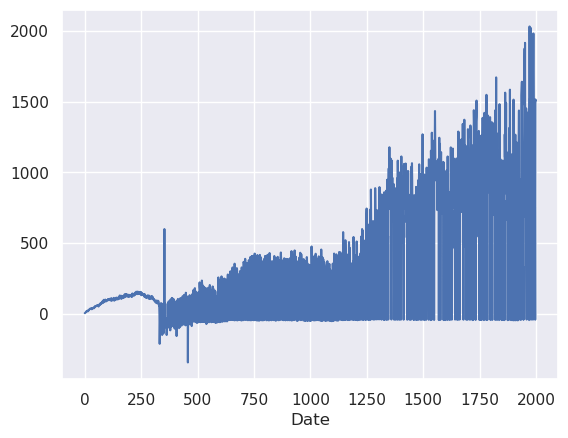

In [366]:
years = 6
months = 12 * years

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(1/a_bar[1:-1000])
print(min(a_bar[1:]))

# Set labels and title
ax.set_xlabel("Date")

# Display the plot
plt.show()

In [304]:
def get_a_given_rank(rank):
    return a[rank-1]

# 3. Backtesting

## 3.1. Backtesting Example

Investment ideas that yield trading strategies can take many different forms:

* buy a stock after it falls by 5%;
* put an equal amount of money in each stock and rebalance each month;
* buy airlines when the oil price falls; 
* buy a stock on the ex-dividend date and sell it afterwards;
* execute some pairs trading (e.g., Coca-Cola and Pepsi).

Such trading strategies are 'quantitative' or 'algorithmic' -- they are based on certain indicators / signals and don't have a human / discretionary component.

*Backtesting* = the process of testing a trading strategy on historical data. 

In contrast to: *Forward testing* (*paper trading*) = Testing a trading strategy for the time period forward, in real time. 

One can evaluate a trading strategy in backtesting by considering several variables, e.g.
* PnL;
* Risk, e.g., standard deviations;
* Drawdowns;
* Sharpe ratio.

When one implements a backtesting engine there are many choices to be made:
    
* Which investment universe?
* Which time periods?

Overall benefits of backtesting:

* Gaining intuition on the overall performance of the trading strategy;
* Understanding the behavior of the trading strategy in different market scenarios;
* Understanding: How much capital is required, holding periods of stocks, turnover;
* Understanding: How does the trading strategy interact with the rest of your portfolio.

There are tons of available online material on backtesting and some popular open-source software packages: e.g., *backtrader* or *zipline* for Python. 

Important to keep in mind: 

**What might have worked in the past might not work in the future.**

### An example: a famous strategy related to momentum trading

A family of quantitative trading strategies are the so called *moving average crossover* strategies. In its simplest form the strategies work as follows. Whenever the moving average of a stock price in a short time window ('*fast moving average*') goes above the moving average in a long time window ('*slow moving average*'), the strategy buys the stock. As soon as the moving average in a short time window goes below, the strategy sells the position.

Let's backtest the long-only component of this strategy with IBM.

In [210]:
p = 12490    # permno of IBM
start_date = '2012-01-1'

In [211]:
with wrds.Connection(wrds_username=WRDS_LOGIN) as db:
    ibm = db.raw_sql("""SELECT dlycaldt, dlyret, dlyprc FROM crsp.StkDlySecurityData 
                        WHERE permno = {} AND dlycaldt >= '{}'
                     """.format(p, start_date), date_cols='dlycaldt').set_index(['dlycaldt'])
ibm.head()

Loading library list...
Done


,dlyret,dlyprc
dlycaldt,,
2012-01-03,0.013161,186.30
2012-01-04,-0.004079,185.54
2012-01-05,-0.004743,184.66
2012-01-06,-0.011481,182.54
2012-01-09,-0.005204,181.59


In [212]:
long_window = 50
short_window = 15

In [213]:
ibm['long_window'] = ibm['dlyprc'].rolling(long_window).mean()
ibm['short_window'] = ibm['dlyprc'].rolling(short_window).mean()
ibm = ibm.dropna()

In [214]:
ibm['long_window'].head(3)

dlycaldt
2012-03-14    191.9416
2012-03-15    192.3356
2012-03-16    192.7450
Name: long_window, dtype: float64

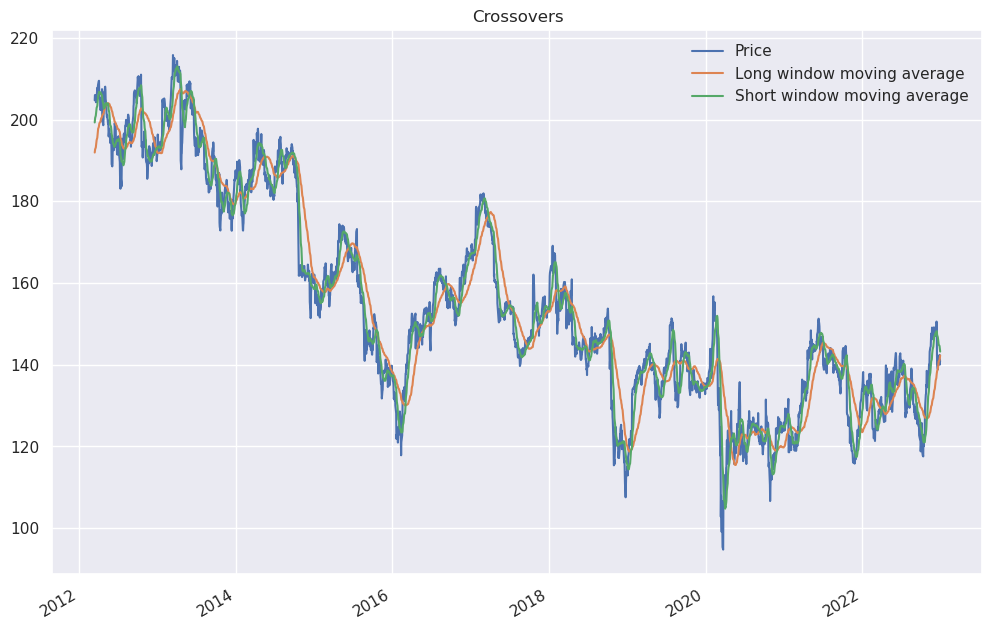

In [215]:
ax = ibm[['dlyprc', 'long_window', 'short_window']].plot(figsize=(12, 8), title='Crossovers')
ax.legend(labels=['Price', 'Long window moving average', 'Short window moving average'], 
          frameon=False)
ax.set_xlabel('');

In [216]:
ibm['trading_strat'] = ibm['short_window'].gt(ibm['long_window']).astype('int').shift(1)
#sum(ibm['trading_strat'][1:].head(50))
print(ibm['trading_strat'][37:41])
print(ibm['short_window'].shift(1)[37:41])
print(ibm['long_window'].shift(1)[37:41])

dlycaldt
2012-05-07    1.0
2012-05-08    1.0
2012-05-09    0.0
2012-05-10    0.0
Name: trading_strat, dtype: float64
dlycaldt
2012-05-07    203.957333
2012-05-08    204.026000
2012-05-09    203.628000
2012-05-10    203.701333
Name: short_window, dtype: float64
dlycaldt
2012-05-07    203.5316
2012-05-08    203.6514
2012-05-09    203.7304
2012-05-10    203.7954
Name: long_window, dtype: float64


The shift by one in the last cell is very important to avoid data leakage. (Why?)

In [217]:
ibm['ret_strat'] = ibm['dlyret'].multiply(ibm['trading_strat'])  
# Here one should also include risk-free rates for times when the strategy doesn't hold the stock.
print(ibm['ret_strat'][35:40])

dlycaldt
2012-05-03   -0.003941
2012-05-04   -0.010857
2012-05-07   -0.006049
2012-05-08   -0.006969
2012-05-09   -0.000000
Name: ret_strat, dtype: float64


In [218]:
ibm['Value_strategy'] = ibm['ret_strat'].add(1).cumprod()
ibm.loc[ibm.index[0], 'Value_strategy'] = 1 

In [219]:
ibm['Value_strategy'].head(3)

dlycaldt
2012-03-14    1.000000
2012-03-15    1.006252
2012-03-16    1.006301
Name: Value_strategy, dtype: float64

In [ ]:
ibm['Value_buy_and_hold'] = ibm['dlyret'].add(1).cumprod()
ibm.loc[ibm.index[0], 'Value_buy_and_hold'] = 1

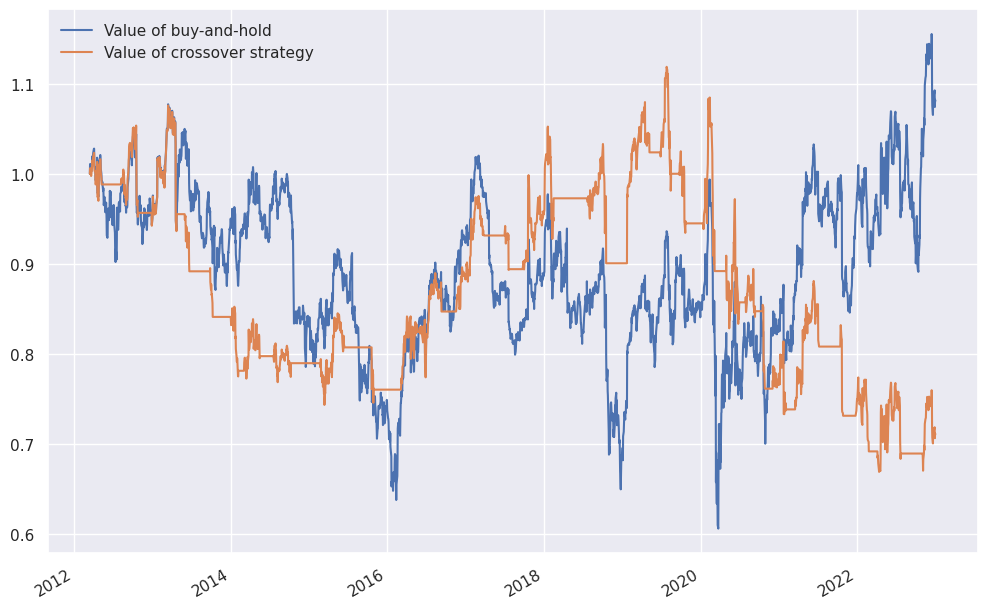

In [ ]:
ax = ibm[['Value_buy_and_hold', 'Value_strategy']].plot(figsize=(12, 8))
ax.legend(labels=['Value of buy-and-hold', 'Value of crossover strategy'], frameon=False);
ax.set_xlabel('');

We see that this strategy (15/50) does well up to about the onset of Covid-19. 

Complete backtesting would have required more steps. We should have included the 'risk-free' returns for the times when the crossover strategy doesn't hold IBM. However, this wouldn't change much here. Additional drawbacks for the crossover strategy are trading costs (which don't incur for the buy-and-hold strategy apart from dividend reinvestments).

* Realistic trading costs should be included (e.g., as done [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3635572) by my former PhD student Desmond Xie).
* Data issues (possibly faulty or missing). We could check, for example, whether changing the flagged returns changes the performance of the strategy.
* Market impact of the trading strategy (e.g., feedback loop).
* Often, only opening and closing prices are available, but it is usually difficult to trade at exactly those prices. Similarly, it's often impossible to trade at certain quoted prices since the supply / demand is not really there, e.g., in FX high-frequency.

**More abstract but highly relevant points to keep in mind:**

* When backtesting be careful not to *over-optimise* to the time series. / *Multiple-testing problem* / *Overfitting*. 
* Be aware of data leakage issues / data snooping / look-ahead bias. For example, due to a mistake (e.g., standardising the returns with the whole historic time series).
* Survivorship bias.

## 3.2. Backtesting Optimal Strategy

The optimal strategy when we assume the Hybrid Jacobi Model under the Pure Open Market setting is given by 
$$
\hat \theta_{n_k(t)}(t) = \frac 1 2 \left( \frac{a_k}{Y_k(t)} + \frac{1}{\bar Y_1^N(t)}(2-\bar a_1^N)\right)
$$

This implies that at every time $t$ we should invest the following percentage of our total wealth in the $k$-ranked stock:
$$
\hat \theta_{n_k(t)}(t)(Y_k(t)) = \frac 1 2 \left( a_k + \frac{Y_k(t)}{\bar Y_1^N(t)}(2-\bar a_1^N)\right)
$$


### Step 1: Define $N$. 

We set a small value, smaller than 300 to start with so that there is always a valid corresponding $a_k$.

In [220]:
N = 100

### Step 2: Compute Weights of the Optimal Strategy

Let's now define a dataframe which will contain the percentage of our total wealth that we should have investited in the $k$-th ranked stock at each given month.

In [222]:
# First, let's set the value of N and compute the sum of the first N elements of the vector a. 
# Then, we will calculate the term (2 - 𝑎̅_1^N) to use it in the formula.
N = 100
a_N = a[:N]  # Take the first N elements of the vector 'a'
a_1_N = a_N.sum()  # Compute the sum of the first N elements
term = 2 - a_1_N  # Compute the term (2 - 𝑎̅_1^N)

In [226]:
print(term)

5.135129415117088


Copy the first N columns of ranked_market_weights.

In [247]:
optimal_strategy_percentage = ranked_market_weights.iloc[:, :N].copy() 
optimal_strategy_percentage.head(3) 

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,0.054194,0.031288,0.024378,0.023660,0.022758,0.019173,0.013656,0.012927,0.012167,0.010197,...,0.001700,0.001686,0.001677,0.001670,0.001664,0.001649,0.001592,0.001587,0.001580,0.001572
1973-02-28,0.056410,0.031000,0.025223,0.023649,0.022552,0.019415,0.014000,0.013706,0.011634,0.010299,...,0.001781,0.001706,0.001700,0.001681,0.001669,0.001658,0.001651,0.001647,0.001621,0.001614
1973-03-30,0.056942,0.031842,0.025874,0.024038,0.023466,0.018063,0.013486,0.013344,0.012014,0.010845,...,0.001748,0.001697,0.001681,0.001680,0.001680,0.001645,0.001645,0.001624,0.001612,0.001582


Compute the term $\bar Y_1^N(t)$ for all $k$ and $t$.

In [248]:
sum_topN_market_weights = ranked_market_weights.iloc[:, :N].sum(axis=1)
sum_topN_market_weights.head(3)

mthcaldt
1973-01-31    0.524141
1973-02-28    0.531478
1973-03-30    0.538169
dtype: float64

Compute the term $\frac{Y_k(t)}{\bar Y_1^N(t)}$ for all $k$ and $t$.

In [249]:
topN_ranked_market_weights = ranked_market_weights.iloc[:, :N]
Yk_divided_by_sumY1N = topN_ranked_market_weights.div(sum_topN_market_weights, axis=0)
Yk_divided_by_sumY1N.head(3)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,0.103396,0.059693,0.046510,0.045140,0.043419,0.036581,0.026054,0.024664,0.023214,0.019454,...,0.003244,0.003217,0.003200,0.003186,0.003175,0.003147,0.003038,0.003028,0.003014,0.002999
1973-02-28,0.106138,0.058327,0.047459,0.044497,0.042432,0.036530,0.026342,0.025788,0.021890,0.019378,...,0.003352,0.003211,0.003199,0.003163,0.003141,0.003119,0.003107,0.003098,0.003050,0.003037
1973-03-30,0.105807,0.059168,0.048078,0.044666,0.043604,0.033564,0.025059,0.024795,0.022325,0.020152,...,0.003248,0.003153,0.003123,0.003121,0.003121,0.003057,0.003057,0.003018,0.002995,0.002940


In [250]:
first_row_sum = Yk_divided_by_sumY1N.iloc[7].sum()
first_row_sum

0.9999999999999994

Calculate the optimal strategy for each $k$ and $t$.

In [251]:
optimal_strategy_percentage = 0.5 * (a_N + Yk_divided_by_sumY1N.mul(term, axis=0))
optimal_strategy_percentage.head(3)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,-1.414123,0.162586,0.154095,0.124131,0.123809,0.105139,0.074960,0.065146,0.063978,0.052526,...,0.008394,0.008461,0.007999,0.007902,0.007945,0.008066,0.008044,0.008079,0.007516,0.007674
1973-02-28,-1.407082,0.159079,0.156532,0.122479,0.121274,0.105010,0.075699,0.068032,0.060579,0.052329,...,0.008671,0.008445,0.007996,0.007843,0.007855,0.007996,0.008222,0.008259,0.007608,0.007771
1973-03-30,-1.407931,0.161238,0.158122,0.122915,0.124282,0.097395,0.072405,0.065482,0.061694,0.054317,...,0.008405,0.008296,0.007802,0.007736,0.007805,0.007836,0.008094,0.008053,0.007466,0.007523


In [253]:
optimal_strategy = optimal_strategy_percentage.div(topN_ranked_market_weights)
optimal_strategy.head(3)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1973-01-31,-26.093763,5.196505,6.321158,5.246499,5.440280,5.483600,5.489146,5.039413,5.258112,5.151241,...,4.937025,5.018081,4.769270,4.732211,4.773579,4.890351,5.052376,5.089636,4.757605,4.882532
1973-02-28,-24.943888,5.131641,6.205830,5.179027,5.377599,5.408684,5.406991,4.963786,5.206956,5.081105,...,4.867643,4.949024,4.703386,4.665677,4.706309,4.822762,4.979240,5.015114,4.693562,4.815321
1973-03-30,-24.725680,5.063626,6.111190,5.113337,5.296243,5.391859,5.368903,4.907332,5.135002,5.008447,...,4.808285,4.889648,4.641861,4.605497,4.647023,4.762642,4.919739,4.957598,4.632703,4.754950


Check Manually One of the Results

In [314]:
date = '1973-02-28'
rank = 3
print(get_a_given_rank(rank))
print(get_weight_given_rank(date, 3))
sum_y_N = 0
for y_k in range(1, N+1):
    sum_y_N += get_weight_given_rank(date, y_k)
print(sum)

sum_a_N = 0
for k in range(1, N+1):
    sum_a_N += get_a_given_rank(k)
print(sum_a_N)

total_perct = 0.5*(get_a_given_rank(rank) + (get_weight_given_rank(date, 3)/sum_y_N)*(2-sum_a_N))
print(total_perct)
print(total_perct == optimal_strategy_percentage.loc[date, 3])

0.06935637490970575
0.025223384202347435
<built-in function sum>
-3.1351294151170883
0.15653202928139814
True


Check that each row in the dataset represents a valid unit decomposition, i.e., that the each row cell is a percentage of the actual wealth.

In [252]:
first_row_sum = optimal_strategy_percentage.iloc[90].sum()
first_row_sum

1.0000000000000016

Define Easy Access Methods.

In [315]:
def get_optimal_perc_given_rank(date, rank):
    return optimal_strategy_percentage.loc[date, rank]

def get_optimal_given_rank(date, rank):
    return optimal_strategy.loc[date, rank]

In [316]:
date = '1973-03-30'
rank = 5

print(get_optimal_perc_given_rank(date, rank))
print(get_optimal_given_rank(date, rank))

0.12428236968709724
5.296243041927063


### Step 3: Backtest

In order to backtest, now I just need to calculate the independent returns made each month given my strategy. For each month I have to calculate this interest. Given a specific month, all I need is to multiply each percentage of stock I own by its generated returns and add (?) all of them.

#### Step 3.1: Given a fixed month, calculate the returns of my strategy that month.

In [325]:
def interest_optimal_one_period(date):
    total_interest = 0
    for rank in range(1, N+1):
        percentage = get_optimal_perc_given_rank(date, rank)
        interest = get_return_given_rank(date, rank)
        total_interest += percentage * interest

    return 1 + total_interest

In [326]:
date = '1973-01-31'
interest_optimal_one_period(date)

0.9235239515537849

#### Step 3.2: Calculate the returns of my strategy over the whole period.

In [329]:
dates_list = optimal_strategy_percentage.index.tolist()

In [332]:
dates_list[0:2]

[Timestamp('1973-01-31 00:00:00'), Timestamp('1973-02-28 00:00:00')]

In [342]:
cumulative_interest = 1 
interests = []
cumulative_interests = []
for date in dates_list:
    interest = interest_optimal_one_period(date)
    interests.append(interest)
    cumulative_interest *= interest
    cumulative_interests.append(cumulative_interest)

print(cumulative_interest)
print(np.mean(interests))

226.7580604047227
1.013057267840256


#### Step 3.3: Plot Interests.

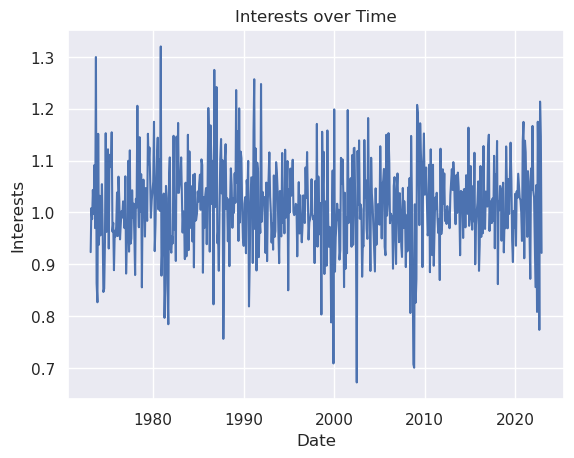

In [339]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(dates_list, interests)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Interests")
ax.set_title("Interests over Time")

# Display the plot
plt.show()

#### Step 3.4: Print Cumulative Interests

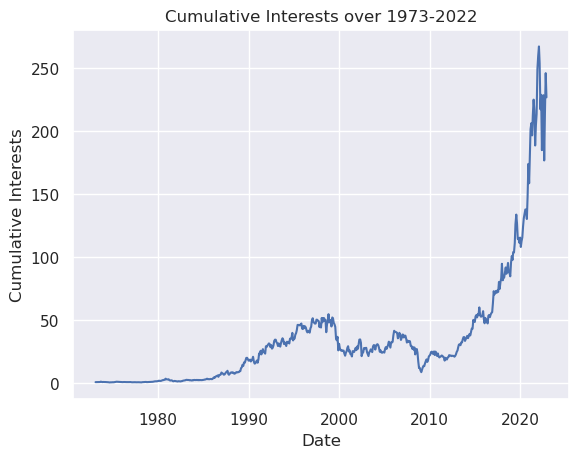

In [350]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(dates_list, cumulative_interests)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Interests")
ax.set_title("Cumulative Interests over 1973-2022")

# Display the plot
plt.show()

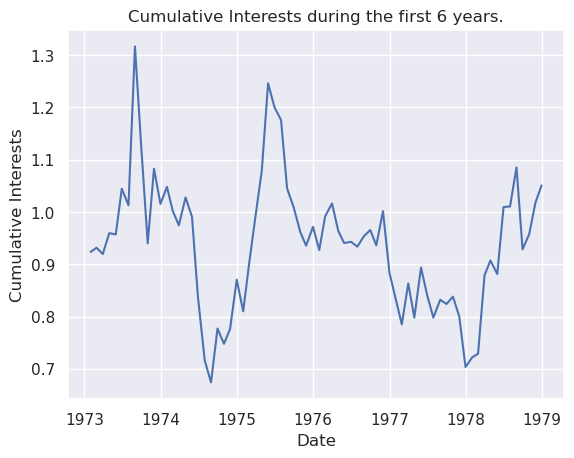

In [349]:
years = 6
months = 12 * years

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(dates_list[0:months], cumulative_interests[0:months])

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Interests")
ax.set_title("Cumulative Interests during the first " + str(years) + " years.")

# Display the plot
plt.show()